# DPG for BipedalWalker

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [13]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.11.0
Default GPU Device: /device:GPU:0


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [15]:
import gym
env = gym.make('BipedalWalker-v2')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [18]:
env.observation_space, env.action_space

(Box(24,), Box(4,))

In [19]:
state = env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action) # take a random action
    batch.append([state, action, next_state, reward, float(done)])
    state = next_state
    if done:
        state = env.reset()

To shut the window showing the simulation, use `env.close()`.

In [20]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [21]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [22]:
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

states: 0.9999559 -0.99969923
actions: 2.3322839736938477 -2.0839174588521323
rewards: 2.3322839736938477 -2.0839174588521323


In [23]:
env.action_space.high, env.action_space.low

(array([1., 1., 1., 1.], dtype=float32),
 array([-1., -1., -1., -1.], dtype=float32))

The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [65]:
def model_input(state_size, action_size):
    #states = tf.placeholder(tf.float32, [None, *state_shape], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.float32, [None, action_size], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    rates = tf.placeholder(tf.float32, [None], name='rates')
    #training = tf.placeholder(tf.bool, [], name='training')
    return states, actions, targetQs, rates

In [66]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        predictions = tf.nn.tanh(logits) # [-1, +1]

        # return actions logits
        return predictions

In [67]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [68]:
# # DDPG
# def model_loss(action_size, hidden_size, states, actions, targetQs, rates):
#     actions_preds = generator(states=states, hidden_size=hidden_size, action_size=action_size)
#     gQs = discriminator(actions=actions_preds, hidden_size=hidden_size, states=states) # nextQs/targetQs
#     gloss = -tf.reduce_mean(gQs)
#     dQs = discriminator(actions=actions, hidden_size=hidden_size, states=states, reuse=True) # Qs
#     targetQs = tf.reshape(targetQs, shape=[-1, 1]) # gQs
#     dloss = tf.reduce_mean(tf.square(dQs - targetQs)) # DQN
#     rates = tf.reshape(rates, shape=[-1, 1]) # [-1,+1]
#     dloss += tf.reduce_mean(tf.square(tf.nn.tanh(dQs) - rates)) # DQN
#     return actions_preds, gQs, gloss, dloss

In [69]:
# Adverseial Q-learning
def model_loss(action_size, hidden_size, states, actions, targetQs, rates):
    actions_preds = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    gQs = discriminator(actions=actions_preds, hidden_size=hidden_size, states=states) # nextQs/targetQs
    dQs = discriminator(actions=actions, hidden_size=hidden_size, states=states, reuse=True) # Qs
    targetQs = tf.reshape(targetQs, shape=[-1, 1]) # gQs
    gloss = tf.reduce_mean(tf.square(gQs - targetQs)) # DQN
    dloss = tf.reduce_mean(tf.square(dQs - targetQs)) # DQN
    dloss += tf.reduce_mean(tf.square(dQs - rates)) # DQN
    return actions_preds, gQs, gloss, dloss

In [70]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, g_learning_rate, d_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(g_learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(d_learning_rate).minimize(d_loss, var_list=d_vars)
    return g_opt, d_opt

In [71]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, g_learning_rate, d_learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.rates = model_input(state_size=state_size, 
                                                                           action_size=action_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_preds, self.Qs_logits, self.g_loss, self.d_loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, targetQs=self.targetQs, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, 
                                           d_loss=self.d_loss,
                                           g_learning_rate=g_learning_rate, 
                                           d_learning_rate=d_learning_rate)

In [72]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [73]:
env.observation_space, env.action_space

(Box(24,), Box(4,))

In [74]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 24
action_size = 4
hidden_size = 24*2             # number of units in each Q-network hidden layer
g_learning_rate = 1e-4         # Q-network learning rate
d_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e2)             # experience mini-batch size == one episode size is 1000/int(1e3) steps
gamma = 0.99                   # future reward discount

In [75]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size,
              g_learning_rate=g_learning_rate, d_learning_rate=d_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [76]:
env.action_space.high, env.action_space.low, env.action_space.shape, \
env.reward_range, env.action_space

(array([1., 1., 1., 1.], dtype=float32),
 array([-1., -1., -1., -1.], dtype=float32),
 (4,),
 (-inf, inf),
 Box(4,))

In [77]:
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

states: 1.4384199778238933 -1.1877236366271973
actions: 1.0 -1.0
rewards: 0.2584633557473608 -0.5476339890559521


In [78]:
state = env.reset()
total_reward = 0
num_step = 0
for each_step in range(memory_size):
    action = env.action_space.sample() # randomness
    action = np.clip(action, -1, 1) # clipped: [-1, +1]
    next_state, reward, done, _ = env.step(action)
    rate = -1 # success rate: [-1, +1]
    memory.buffer.append([state, action, next_state, reward, float(done), rate])
    num_step += 1 # memory updated
    total_reward += reward # max reward 300
    state = next_state
    if done is True:
        print('Progress:', each_step/memory_size)
        state = env.reset()
        # Best 100-episode average reward was 220.62 ± 0.69. 
        # (BipedalWalker-v2 is considered "solved" 
        #  when the agent obtains an average reward of at least 300 over 100 consecutive episodes.)        
        rate = total_reward/300
        rate = np.clip(rate, -1, 1) 
        total_reward = 0 # reset
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1:
                memory.buffer[-1-idx][-1] = rate
        num_step = 0 # reset

Progress: 0.00054
Progress: 0.00113
Progress: 0.01713
Progress: 0.01761
Progress: 0.01807
Progress: 0.01873
Progress: 0.03473
Progress: 0.05073
Progress: 0.05152
Progress: 0.05209
Progress: 0.05309
Progress: 0.06909
Progress: 0.06988
Progress: 0.07081
Progress: 0.07143
Progress: 0.07224
Progress: 0.08824
Progress: 0.10424
Progress: 0.10513
Progress: 0.10876
Progress: 0.10964
Progress: 0.12564
Progress: 0.14164
Progress: 0.15764
Progress: 0.15836
Progress: 0.17436
Progress: 0.17495
Progress: 0.17543
Progress: 0.17613
Progress: 0.19213
Progress: 0.19305
Progress: 0.19373
Progress: 0.19464
Progress: 0.21064
Progress: 0.22664
Progress: 0.22739
Progress: 0.2286
Progress: 0.22971
Progress: 0.23053
Progress: 0.23143
Progress: 0.23219
Progress: 0.23275
Progress: 0.23387
Progress: 0.24987
Progress: 0.25041
Progress: 0.25135
Progress: 0.25216
Progress: 0.25287
Progress: 0.25408
Progress: 0.25469
Progress: 0.2553
Progress: 0.2713
Progress: 0.2873
Progress: 0.28794
Progress: 0.30394
Progress: 0.31

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [79]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list, gloss_list, dloss_list = [], [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model2.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
    
    # Training episodes/epochs
    for ep in range(111):
        total_reward = 0
        num_step = 0
        gloss_batch, dloss_batch = [], []
        state = env.reset()

        # Training steps/batches
        while True:
            action_preds = sess.run(model.actions_preds, feed_dict={model.states: state.reshape([1, -1])})
            noise = np.random.normal(loc=0, scale=0.1, size=action_size) # randomness
            action = action_preds.reshape([-1]) + noise
            #print(action.shape, action_logits.shape, noise.shape)
            action = np.clip(action, -1, 1) # clipped
            next_state, reward, done, _ = env.step(action)
            rate = -1 # success rate: -1 to +1
            memory.buffer.append([state, action, next_state, reward, float(done), rate])
            num_step += 1 # memory updated
            total_reward += reward # max reward 300
            state = next_state
            
            if done is True:
                # Best 100-episode average reward was 220.62 ± 0.69. 
                # (BipedalWalker-v2 is considered "solved" 
                #  when the agent obtains an average reward of at least 300 over 100 consecutive episodes.)        
                rate = total_reward/300
                rate = np.clip(rate, -1, 1)
                for idx in range(num_step): # episode length
                    if memory.buffer[-1-idx][-1] == -1:
                        memory.buffer[-1-idx][-1] = rate
                        
            # Training
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            next_states = np.array([each[2] for each in batch])
            rewards = np.array([each[3] for each in batch])
            dones = np.array([each[4] for each in batch])
            #rates = np.array([each[5] for each in batch])
            nextQs_logits = sess.run(model.Qs_logits, feed_dict = {model.states: next_states})
            #nextQs = np.max(nextQs_logits, axis=1) * (1-dones) # discrete DQN
            nextQs = nextQs_logits.reshape([-1]) * (1-dones) # continuous DPG
            targetQs = rewards + (gamma * nextQs)
            gloss, dloss, _, _ = sess.run([model.g_loss, model.d_loss, model.g_opt, model.d_opt],
                                          feed_dict = {model.states: states, 
                                                       model.actions: actions,
                                                       model.targetQs: targetQs, 
                                                       model.rates: rewards})
            gloss_batch.append(gloss)
            dloss_batch.append(dloss)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'gloss:{:.4f}'.format(np.mean(gloss_batch)),
              'dloss:{:.4f}'.format(np.mean(dloss_batch)))
        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        gloss_list.append([ep, np.mean(gloss_batch)])
        dloss_list.append([ep, np.mean(dloss_batch)])
        # Break episode/epoch loop
        # Did not solve the environment. 
        # Best 100-episode average reward was 220.62 ± 0.69. 
        # (BipedalWalker-v2 is considered "solved" 
        #  when the agent obtains an average reward of at least 300 over 100 consecutive episodes.)        
        if np.mean(episode_reward) >= 300:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:-105.0810 R:-105.0810 gloss:9.6885 dloss:19.5605
Episode:1 meanR:-107.4824 R:-109.8838 gloss:19.5432 dloss:39.3230
Episode:2 meanR:-107.4221 R:-107.3015 gloss:9.7995 dloss:19.9239
Episode:3 meanR:-107.9657 R:-109.5965 gloss:13.1455 dloss:26.8188
Episode:4 meanR:-118.0846 R:-158.5604 gloss:12.7504 dloss:26.3640
Episode:5 meanR:-127.0676 R:-171.9825 gloss:11.4446 dloss:23.3819
Episode:6 meanR:-132.3294 R:-163.8998 gloss:12.4697 dloss:25.4616
Episode:7 meanR:-129.1102 R:-106.5759 gloss:19.6181 dloss:39.9439
Episode:8 meanR:-126.5406 R:-105.9841 gloss:12.2676 dloss:25.1319
Episode:9 meanR:-124.4823 R:-105.9577 gloss:16.6749 dloss:34.0601
Episode:10 meanR:-122.4653 R:-102.2948 gloss:9.9344 dloss:20.4668
Episode:11 meanR:-121.1478 R:-106.6556 gloss:8.3509 dloss:17.2455
Episode:12 meanR:-120.0314 R:-106.6344 gloss:12.7644 dloss:26.1725
Episode:13 meanR:-119.0739 R:-106.6268 gloss:19.1744 dloss:39.0631
Episode:14 meanR:-117.9405 R:-102.0735 gloss:7.2763 dloss:15.0757
Episode:15

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [80]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

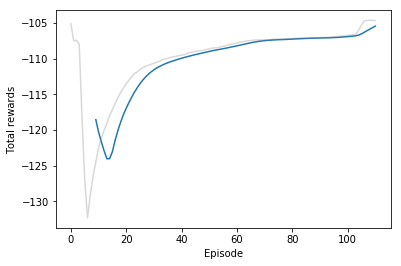

In [81]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

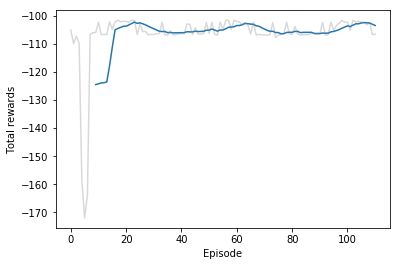

In [82]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'G losses')

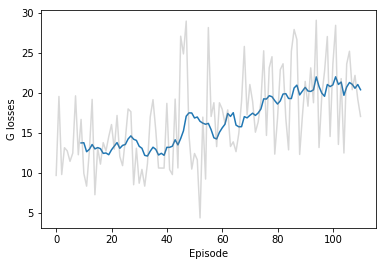

In [83]:
eps, arr = np.array(gloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0, 0.5, 'D losses')

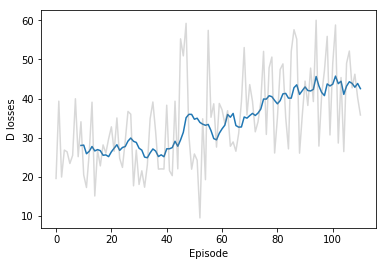

In [84]:
eps, arr = np.array(dloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [85]:
import gym
env = gym.make('BipedalWalker-v2')

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_preds = sess.run(model.actions_preds, feed_dict={model.states: state.reshape([1, -1])})
            action = np.reshape(action_preds, [-1]) # For continuous action space
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
# End the env                
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: -103.43347330792993


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.